# Process and Plot the Relationship Between BA Temperature and Interconnection Load Extremes

This notebook analyzes the relationship between Balancing Authority (BA) temperature extremes and interconnection load extremes.

In [92]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


## Set the Directory Structure

In [181]:
# Identify the data input and output directories:
weather_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/historic/'
load_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/postprocessed/interconnection_load_time_series/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/'
data_output_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/postprocessed/ba_temperature_to_interconnection_load_extremes/'
image_output_dir =  '/Users/burl878/Documents/IMMM/Images/TELL/Analysis/BA_Temperature_to_Interconnection_Load_Extremes/'


## Process the Historical Relationship Data

In [107]:
# Define a function to process the time series of BA temperature and interconnection load:
def process_extreme_relationships(weather_data_input_dir: str, load_data_input_dir: str, data_output_dir: str, ba_to_process: str, interconnection: str):
    # Read in the historical interconnection loads file:
    ics_df = pd.read_csv(load_data_input_dir + 'historic.csv')
    
    # Subset to just the data for the interconnection being processed:
    ics_df = ics_df.loc[ics_df['Interconnection'] == interconnection]
    
    # Rename some variables for simplicity:
    ics_df.rename(columns={'Interconnection_Load_MWh': 'Load_MWh', 'Percentile': 'Load_Percentile'}, inplace=True)
    
    # Loop over the years from the 1980 to 2019:
    for year in range(1980,2020,1):
        # Read in the historical meteorology.csv file:
        met_df = pd.read_csv((weather_data_input_dir + ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv'))
        
        # Set the time value as a datetime variable:
        met_df['Datetime'] = pd.to_datetime(met_df['Time_UTC'])
        
        # Add a column with the month values to be used in grouping:
        met_df['Month'] = met_df['Datetime'].dt.strftime('%m').astype(str).astype(int)
        
        # Convert the temperature from Kelvin to Fahrenheit:
        met_df['T2_F'] = ((1.8 * (met_df['T2'] - 273)) + 32).round(2)
        
        # Compute the annual percentile for each hourly temperature value:
        met_df['T2_Percentile'] = met_df['T2_F'].rank(pct=True).round(3)
        
        # Merge the met_df and ics_df dataframes based on common time values:
        merged_df = met_df.merge(ics_df, on=['Time_UTC'])
        
        # Subset to just the variables we need:
        merged_df = merged_df[['Time_UTC', 'Month', 'T2_F', 'T2_Percentile', 'Load_MWh', 'Load_Percentile']].copy()
        
        # Aggregate the output into a new dataframe:
        if year == 1980:
           output_df = merged_df
        else:
           output_df = pd.concat([output_df , merged_df])
    
    # Subset the output_df to just the summer and winter months:
    winter_df = output_df.loc[(output_df['Month'] == 1) | (output_df['Month'] == 2) | (output_df['Month'] == 3) | (output_df['Month'] == 10) | (output_df['Month'] == 11) | (output_df['Month'] == 12)]
    summer_df = output_df.loc[(output_df['Month'] == 4) | (output_df['Month'] == 5) | (output_df['Month'] == 6) | (output_df['Month'] == 7) | (output_df['Month'] == 8) | (output_df['Month'] == 9)]

    # Compute the correlations between the BA T2 percentile and the interconnection load percentile:
    all_corr = output_df['T2_Percentile'].corr(output_df['Load_Percentile']).round(2)
    winter_corr = winter_df['T2_Percentile'].corr(winter_df['Load_Percentile']).round(2)
    summer_corr = summer_df['T2_Percentile'].corr(summer_df['Load_Percentile']).round(2)

    #Initiate a counter and empty dataframe to store the results:
    counter = 0;
    stats_df = pd.DataFrame()

    # Loop over the range of T2 percentile values:
    for bin in np.arange(0,1,0.02):
        # Iterate the counter by one:
        counter = counter + 1 
    
        # Put the statistics in a new dataframe:
        stats_df.loc[counter, 'BA'] = ba_to_process
        stats_df.loc[counter, 'Bin'] = ((bin+(bin+0.02)) / 2)
        stats_df.loc[counter, 'All_Corr'] = all_corr
        stats_df.loc[counter, 'Winter_Corr'] = winter_corr
        stats_df.loc[counter, 'Summer_Corr'] = summer_corr
        
        # Subset the data to just the T2 values in a given bin and compute the corresponding mean load percentile:
        all_subset_df = output_df.loc[(output_df['T2_Percentile'] >= bin) & (output_df['T2_Percentile'] < (bin+0.02))]
        if all_subset_df.empty == False:
           stats_df.loc[counter, 'All_Mean'] = all_subset_df['Load_Percentile'].mean().round(2)
        else:
           stats_df.loc[counter, 'All_Mean'] = np.nan
        del all_subset_df
    
        # Do the same except for the winter subset:
        winter_subset_df = winter_df.loc[(winter_df['T2_Percentile'] >= bin) & (winter_df['T2_Percentile'] < (bin+0.02))]
        if winter_subset_df.empty == False:
           stats_df.loc[counter, 'Winter_Mean'] = winter_subset_df['Load_Percentile'].mean().round(2)
        else:
           stats_df.loc[counter, 'Winter_Mean'] = np.nan
        del winter_subset_df
    
        # Do the same except for the summer subset:
        summer_subset_df = summer_df.loc[(summer_df['T2_Percentile'] >= bin) & (summer_df['T2_Percentile'] < (bin+0.02))]
        if summer_subset_df.empty == False:
           stats_df.loc[counter, 'Summer_Mean'] = summer_subset_df['Load_Percentile'].mean().round(2)
        else:
           stats_df.loc[counter, 'Summer_Mean'] = np.nan
        del summer_subset_df

    # Write out the time series dataframe to a .csv file:
    output_df.to_csv((os.path.join(data_output_dir + ba_to_process + '_BA_Temperature_to_Interconnection_Load_Extremes.csv')), sep=',', index=False)
    stats_df.to_csv((os.path.join(data_output_dir + ba_to_process + '_BA_Temperature_to_Interconnection_Load_Extremes_Statistics.csv')), sep=',', index=False)
    
    return output_df, stats_df


In [149]:
output_df, stats_df = process_extreme_relationships(weather_data_input_dir = weather_data_input_dir,
                                                    load_data_input_dir = load_data_input_dir, 
                                                    data_output_dir = data_output_dir, 
                                                    ba_to_process = 'PSCO',
                                                    interconnection = 'WECC')

stats_df


,BA,Bin,All_Corr,Winter_Corr,Summer_Corr,All_Mean,Winter_Mean,Summer_Mean
1,PSCO,0.01,0.35,-0.06,0.66,0.60,0.60,0.11
2,PSCO,0.03,0.35,-0.06,0.66,0.54,0.54,0.19
3,PSCO,0.05,0.35,-0.06,0.66,0.50,0.51,0.21
4,PSCO,0.07,0.35,-0.06,0.66,0.49,0.50,0.22
5,PSCO,0.09,0.35,-0.06,0.66,0.48,0.48,0.21
6,PSCO,0.11,0.35,-0.06,0.66,0.46,0.47,0.23
7,PSCO,0.13,0.35,-0.06,0.66,0.45,0.47,0.21
8,PSCO,0.15,0.35,-0.06,0.66,0.44,0.46,0.20
9,PSCO,0.17,0.35,-0.06,0.66,0.43,0.46,0.19
10,PSCO,0.19,0.35,-0.06,0.66,0.43,0.45,0.23


In [153]:
# Define a function to plot the relationship between BA temperature and interconnection load extremes:
def plot_extreme_relationships(ba_to_plot: str, interconnection: str, data_output_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the output already exist and if not then process it:
    if os.path.isfile((os.path.join(data_output_dir + ba_to_plot + '_BA_Temperature_to_Interconnection_Load_Extremes.csv'))) == True:
       # Load in the pre-processed data:
       output_df = pd.read_csv((os.path.join(data_output_dir + ba_to_plot + '_BA_Temperature_to_Interconnection_Load_Extremes.csv')))
       stats_df = pd.read_csv((os.path.join(data_output_dir + ba_to_plot + '_BA_Temperature_to_Interconnection_Load_Extremes_Statistics.csv')))
    else:
       output_df, stats_df = process_extreme_relationships(weather_data_input_dir = weather_data_input_dir,
                                                           load_data_input_dir = load_data_input_dir, 
                                                           data_output_dir = data_output_dir, 
                                                           ba_to_process = ba_to_plot,
                                                           interconnection = interconnection)
    
    # Subset the output_df to just the summer and winter months:
    winter_df = output_df.loc[(output_df['Month'] == 1) | (output_df['Month'] == 2) | (output_df['Month'] == 3) | (output_df['Month'] == 10) | (output_df['Month'] == 11) | (output_df['Month'] == 12)]
    summer_df = output_df.loc[(output_df['Month'] == 4) | (output_df['Month'] == 5) | (output_df['Month'] == 6) | (output_df['Month'] == 7) | (output_df['Month'] == 8) | (output_df['Month'] == 9)]

    # Make the plot:
    plt.figure(figsize=(25, 10))
    plt.rcParams['font.size'] = 12
    
    # Plot the results using all of the data:
    plt.subplot(211)
    plt.scatter(output_df['T2_Percentile'], output_df['Load_Percentile'], s=5, c='gray', label='Individual Hour')
    plt.plot(stats_df['Bin'], stats_df['All_Mean'], 'k', linewidth=3, label=('Mean: Correlation = ' + stats_df['All_Corr'].mean().round(2).astype(str)))
    plt.legend(loc='upper left'); plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.grid(True)
    plt.xlabel(('2-m Air Temperature Percentile in ' + ba_to_plot));
    plt.ylabel(('Total Load Percentile in the ' + interconnection))
    plt.title(('All Data (1980-2019): ' + ba_to_plot + ' Temperatures vs. ' + interconnection + ' Total Loads'))
    
    # Plot the results using only the summer data:
    plt.subplot(223)
    plt.scatter(summer_df['T2_Percentile'], summer_df['Load_Percentile'], s=5, c='red', label='Individual Hour')
    plt.plot(stats_df['Bin'], stats_df['Summer_Mean'], 'k', linewidth=3, label=('Mean: Correlation = ' + stats_df['Summer_Corr'].mean().round(2).astype(str)))
    plt.legend(loc='upper left'); plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.grid(True)
    plt.xlabel(('2-m Air Temperature Percentile in ' + ba_to_plot));
    plt.ylabel(('Total Load Percentile in the ' + interconnection))
    plt.title(('Only Summer Data'))
    
    # Plot the results using only the winter data:
    plt.subplot(224)
    plt.scatter(winter_df['T2_Percentile'], winter_df['Load_Percentile'], s=5, c='blue', label='Individual Hour')
    plt.plot(stats_df['Bin'], stats_df['Winter_Mean'], 'k', linewidth=3, label=('Mean: Correlation = ' + stats_df['Winter_Corr'].mean().round(2).astype(str)))
    plt.legend(loc='upper left'); plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.grid(True)
    plt.xlabel(('2-m Air Temperature Percentile in ' + ba_to_plot));
    plt.ylabel(('Total Load Percentile in the ' + interconnection))
    plt.title(('Only Winter Data'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (ba_to_plot + '_Extremes_Relationships.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


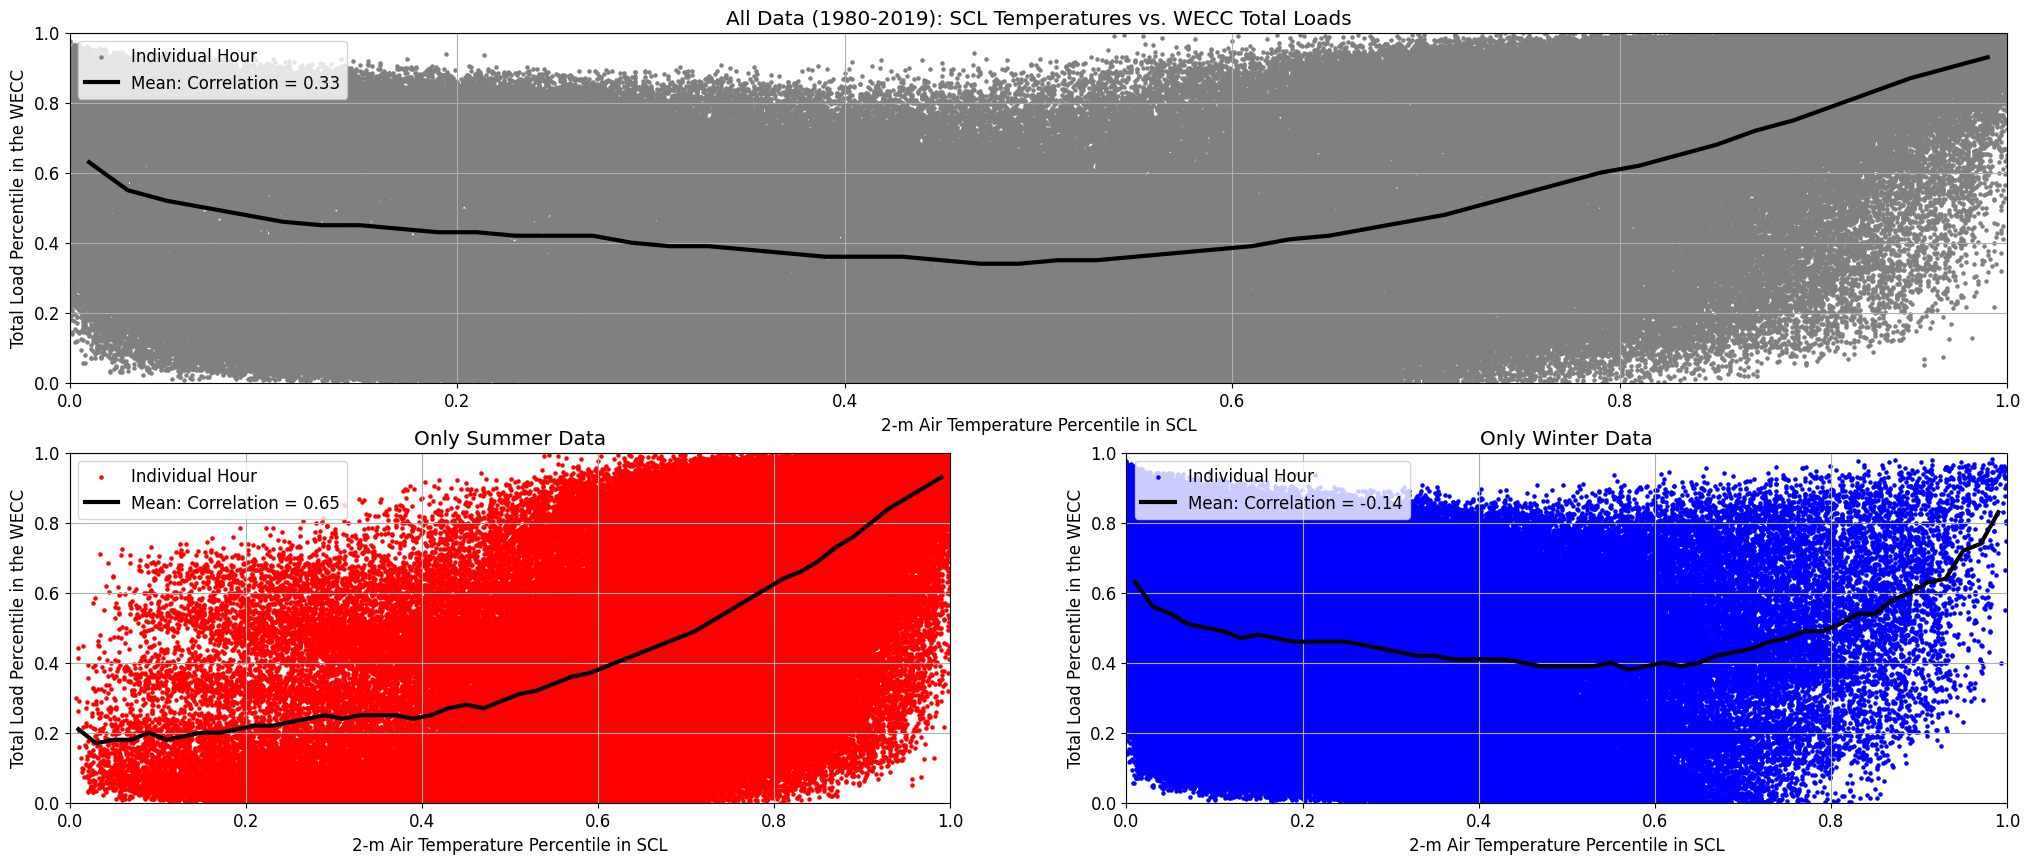

In [198]:
plot_extreme_relationships(ba_to_plot = 'SCL',
                           interconnection = 'WECC',
                           data_output_dir = data_output_dir,
                           image_output_dir = image_output_dir, 
                           image_resolution = 300, 
                           save_images = True)


In [205]:
# Define a function to plot the relationships across BAs in an interconnection:
def plot_ba_to_interconnection_relationships(interconnection: str, metadata_input_dir: str, data_output_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    # Read in the BA-to-Interconnection mapping file:
    ba_mapping = pd.read_csv(metadata_input_dir + 'BA_to_Interconnection_Mapping.csv')
    
    # Subset to just the interconnection being analyzed:
    ba_mapping = ba_mapping.loc[ba_mapping['Interconnection'] == interconnection]
    
    # Make a list of all of the BAs in "ba_mapping":
    bas = ba_mapping['BA_Code'].unique()
    
    #Initiate an empty dataframe to store the results:
    corr_df = pd.DataFrame()
    
    # Loop over the BAs and concatenate their statistics files:
    for i in range(len(bas)):
        # Read in the statistics for the BA being processed:
        stats_df = pd.read_csv((os.path.join(data_output_dir + bas[i] + '_BA_Temperature_to_Interconnection_Load_Extremes_Statistics.csv')))

        # Extract the correlation statistics:
        corr_df.loc[i, 'BA'] = bas[i]
        corr_df.loc[i, 'All_Corr'] = stats_df['All_Corr'].mean().round(2)
        corr_df.loc[i, 'Winter_Corr'] = stats_df['Winter_Corr'].mean().round(2)
        corr_df.loc[i, 'Summer_Corr'] = stats_df['Summer_Corr'].mean().round(2)
        
        # Aggregate the statistics into a new dataframe:
        if i == 0:
           agg_df = stats_df
        else:
           agg_df = pd.concat([agg_df, stats_df])
    
    return agg_df
        

In [206]:
a = plot_ba_to_interconnection_relationships(interconnection = 'WECC',
                                             metadata_input_dir = metadata_input_dir,
                                             data_output_dir = data_output_dir,
                                             image_output_dir = image_output_dir, 
                                             image_resolution = 300, 
                                             save_images = True)

a


,BA,Bin,All_Corr,Winter_Corr,Summer_Corr,All_Mean,Winter_Mean,Summer_Mean
0,AVA,0.01,0.33,-0.15,0.72,0.64,0.64,NaN
1,AVA,0.03,0.33,-0.15,0.72,0.58,0.58,NaN
2,AVA,0.05,0.33,-0.15,0.72,0.56,0.56,NaN
3,AVA,0.07,0.33,-0.15,0.72,0.54,0.54,0.15
4,AVA,0.09,0.33,-0.15,0.72,0.51,0.51,0.15
...,...,...,...,...,...,...,...,...
45,WAUW,0.91,0.32,-0.15,0.68,0.82,0.74,0.82
46,WAUW,0.93,0.32,-0.15,0.68,0.85,0.77,0.85
47,WAUW,0.95,0.32,-0.15,0.68,0.88,0.78,0.88
48,WAUW,0.97,0.32,-0.15,0.68,0.91,0.73,0.91
